# Mission1: 오염원 첫 발견

## EDA

In [ ]:
# 환경 준비 & 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, math, random, glob, ast, itertools
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

Mounted at /content/drive


In [ ]:
# 경로 설정
TRAIN_IMG_DIR = '/content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Training/01.원천데이터/TS_KS' # 원본 훈련 이미지
TRAIN_ANN_PATH = '/content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Training/02.라벨링데이터/TL_KS_BBOX' # 원본 이미지의 라벨(바운딩박스) - 파일(.json/.csv) 또는 폴더 허용

# 평가(검증) 이미지
VAL_IMG_DIR   = '/content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Validation/01.원천데이터/VS_KS' # 평가(검증) 이미지
VAL_ANN_PATH  = '/content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Validation/02.라벨링데이터/VL_KS_BBOX' # 평가 이미지 라벨(바운딩박스)

IMG_EXTS = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')

IMG_SIZE = (512, 512) # 문제 기준: Kompsat-3/3A 512x512 JPG


In [ ]:
# =========================
# 라벨 경로 자동 해석 & 전체 병합 로딩 (파일/폴더 모두 지원)
# =========================
# 설명:
# - 폴더면 내부의 모든 .json/.csv 파일을 재귀적으로 찾아 "모두" 병합해서 로딩합니다.
# - 파일이면 해당 파일 1개를 로딩합니다.
# - 최종적으로 train_ann / val_ann 딕셔너리를 이 블록에서 만들어줍니다.
# - 이후 셀들은 기존대로 df 구성/EDA 진행하면 됩니다.

def _list_label_files(path_like):
    """path_like가 파일이면 [그 파일], 폴더면 내부 모든 .json/.csv(재귀) 리스트 반환"""
    if os.path.isfile(path_like):
        return [path_like] if path_like.lower().endswith(('.json', '.csv')) else []
    if os.path.isdir(path_like):
        files = sorted(
            glob.glob(os.path.join(path_like, '**', '*.json'), recursive=True) +
            glob.glob(os.path.join(path_like, '**', '*.csv'),  recursive=True)
        )
        return files
    return []

def _load_via_file_to_dict(path):
    """VIA 단일 파일 로더(기존 load_via_annotations 재사용 가능)"""
    if 'load_via_annotations' in globals(): # 간단 파서(없는 경우)
        return load_via_annotations(path)
    # (fallback)
    ann = defaultdict(list)
    if path.lower().endswith('.json'):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except Exception as e:
            print(f"[WARN] JSON read failed: {path} ({e})")
            return ann
        # VIA 3.x
        if isinstance(data, dict) and 'metadata' in data:
            files = data.get('file', {})
            id2name = {fid: info.get('name', f'unknown_{fid}') for fid, info in files.items()}
            for _, m in data['metadata'].items():
                fname = id2name.get(m.get('file'))
                sa = m.get('xy') or m.get('shape_attributes')
                if not fname or not sa:
                    continue
                if isinstance(sa, dict) and sa.get('name') == 'rect':
                    ann[fname].append({'x':sa.get('x',0),'y':sa.get('y',0),
                                       'width':sa.get('width',0),'height':sa.get('height',0)})
                elif isinstance(sa, list) and len(sa) >= 4:
                    x,y,w,h = sa[:4]
                    ann[fname].append({'x':x,'y':y,'width':w,'height':h})
        # VIA 2.x
        elif isinstance(data, dict):
            for _, item in data.items():
                if not isinstance(item, dict):
                    continue
                fname = item.get('filename')
                for r in item.get('regions', []):
                    sa = r.get('shape_attributes', {})
                    if sa.get('name') == 'rect':
                        ann[fname].append({'x':sa.get('x',0),'y':sa.get('y',0),
                                           'width':sa.get('width',0),'height':sa.get('height',0)})
    elif path.lower().endswith('.csv'):
        try:
            df = pd.read_csv(path)
        except Exception as e:
            print(f"[WARN] CSV read failed: {path} ({e})")
            return ann
        fname_col = next((c for c in df.columns if c.lower()=='filename'), None)
        rsa_col   = next((c for c in df.columns if 'region_shape_attributes' in c), None)
        if fname_col and rsa_col:
            for _, row in df.iterrows():
                fname = row[fname_col]
                try:
                    sa = json.loads(row[rsa_col])
                except:
                    try:
                        sa = ast.literal_eval(row[rsa_col])
                    except:
                        sa = {}
                if isinstance(sa, dict) and sa.get('name') == 'rect':
                    ann[fname].append({'x':sa.get('x',0),'y':sa.get('y',0),
                                       'width':sa.get('width',0),'height':sa.get('height',0)})
    return ann

def _merge_ann_dict(dst, src):
    for k, v in src.items():
        dst[k].extend(v)

def load_all_via_annotations(path_like):
    """폴더면 모든 파일 병합, 파일이면 1개 로딩 → 단일 ann dict로 반환"""
    files = _list_label_files(path_like)
    ann = defaultdict(list)
    if not files:
        print(f"[WARN] No JSON/CSV found under: {path_like}")
        return ann
    # 참고 로그: 상위 5개
    print(f"[INFO] VIA files to load: {len(files)} (showing top 5)")
    for fp in files[:5]:
        try:
            sz = os.path.getsize(fp)/1e6
        except:
            sz = 0.0
        print(f"  - {os.path.basename(fp)} | size ~ {sz:.2f} MB")
    # 병합 로딩
    for fp in files:
        _merge_ann_dict(ann, _load_via_file_to_dict(fp))
    return ann

# === 로딩 실행 ===
train_ann = load_all_via_annotations(TRAIN_ANN_PATH)
val_ann   = load_all_via_annotations(VAL_ANN_PATH)

# === 경로/개수 확인 ===
print('\n[PATH CHECK / COUNTS]')
print('TRAIN_IMG_DIR:', TRAIN_IMG_DIR, '->', len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*'))))
print('VAL_IMG_DIR  :', VAL_IMG_DIR,   '->', len(glob.glob(os.path.join(VAL_IMG_DIR,   '*'))))
print('TRAIN_ANN DIR/FILE:', TRAIN_ANN_PATH)
print('VAL_ANN   DIR/FILE:', VAL_ANN_PATH)
print('Train 라벨된 이미지 수(파일명 기준 key 개수):', len(train_ann))
print('Val   라벨된 이미지 수(파일명 기준 key 개수):', len(val_ann))

[INFO] VIA files to load: 8052 (showing top 5)
  - K3A_CHN_20161112052404_0.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_1.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_10.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_11.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_12.json | size ~ 0.00 MB
[INFO] VIA files to load: 1006 (showing top 5)
  - K3A_CHN_20161112052404_15.json | size ~ 0.00 MB
  - K3A_CHN_20170115051130_1.json | size ~ 0.00 MB
  - K3A_CHN_20170123052151_1.json | size ~ 0.00 MB
  - K3A_CHN_20170123052151_14.json | size ~ 0.00 MB
  - K3A_CHN_20170123052151_22.json | size ~ 0.00 MB

[PATH CHECK / COUNTS]
TRAIN_IMG_DIR: /content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Training/01.원천데이터/TS_KS -> 8052
VAL_IMG_DIR  : /content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Validation/01.원천데이터/VS_KS -> 1006
TRAIN_ANN DIR/FILE: /content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Training/02.라벨링데이터/TL_KS_BBOX
VAL_ANN   DIR/FILE: /content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터/Validation/02.라벨링

In [ ]:
# Train 데이터셋 확인

# 실제 이미지 파일 목록
train_image_files = {os.path.basename(p) for p in glob.glob(os.path.join(TRAIN_IMG_DIR, '*')) if p.endswith(IMG_EXTS)}
# 라벨 파일에 명시된 파일명 목록
train_labeled_files = set(train_ann.keys())

print(f"\n[Train Set]")
print(f"실제 이미지 파일 개수: {len(train_image_files)}")
print(f"라벨링된 파일 개수: {len(train_labeled_files)}")

# 이미지는 있지만, 라벨이 없는 경우를 확인합니다.
unlabeled_in_train = train_image_files - train_labeled_files
if not unlabeled_in_train:
    print("모든 이미지에 라벨이 존재합니다.")
else:
    print(f"[경고] 이미지는 있으나 라벨이 없는 파일: {len(unlabeled_in_train)}개")

# 라벨은 있지만, 이미지가 없는 경우를 확인합니다.
missing_images_in_train = train_labeled_files - train_image_files
if not missing_images_in_train:
    print("모든 라벨에 해당하는 이미지가 존재합니다.")
else:
    print(f"[경고] 라벨은 있으나 이미지가 없는 파일: {len(missing_images_in_train)}개")


# Validation 데이터셋 확인
val_image_files = {os.path.basename(p) for p in glob.glob(os.path.join(VAL_IMG_DIR, '*')) if p.endswith(IMG_EXTS)}
val_labeled_files = set(val_ann.keys())

print(f"\n[Validation Set]")
print(f"실제 이미지 파일 개수: {len(val_image_files)}")
print(f"라벨링된 파일 개수: {len(val_labeled_files)}")

unlabeled_in_val = val_image_files - val_labeled_files
if not unlabeled_in_val:
    print("모든 이미지에 라벨이 존재합니다.")
else:
    print(f"[경고] 이미지는 있으나 라벨이 없는 파일: {len(unlabeled_in_val)}개")

missing_images_in_val = val_labeled_files - val_image_files
if not missing_images_in_val:
    print("모든 라벨에 해당하는 이미지가 존재합니다.")
else:
    print(f"[경고] 라벨은 있으나 이미지가 없는 파일: {len(missing_images_in_val)}개")

print("\n 데이터 정합성 검사를 완료했습니다.")


[Train Set]
실제 이미지 파일 개수: 8052
라벨링된 파일 개수: 8052
모든 이미지에 라벨이 존재합니다.
모든 라벨에 해당하는 이미지가 존재합니다.

[Validation Set]
실제 이미지 파일 개수: 1006
라벨링된 파일 개수: 1006
모든 이미지에 라벨이 존재합니다.
모든 라벨에 해당하는 이미지가 존재합니다.

 데이터 정합성 검사를 완료했습니다.


In [ ]:
# 유틸
# VIA 라벨 로더 (JSON/CSV 자동 인식)
def load_via_annotations(path):
    """
    VIA(VGG Image Annotator) 형식 라벨을 JSON 또는 CSV에서 읽어와,
    {filename: [{'x':..., 'y':..., 'width':..., 'height':...}, ...]} 형태로 반환합니다.
    """
    ann = defaultdict(list)
    if path is None or (not os.path.exists(path)):
        print(f"[경고] 라벨 파일이 없습니다: {path}")
        return ann

    if path.lower().endswith('.json'):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # VIA 3.x: {'metadata': {...}, 'file': {...}} 구조
        if isinstance(data, dict) and 'metadata' in data:
            meta = data['metadata']
            files = data.get('file', {})
            file_id_to_name = {fid: finfo.get('name', f'unknown_{fid}') for fid, finfo in files.items()}
            for _, m in meta.items():
                fid = m.get('file', None)
                fname = file_id_to_name.get(fid, None)
                if not fname:
                    continue
                # VIA3 = ('xy' 배열 or 'shape_attributes' dict)
                sa = m.get('xy', None) or m.get('shape_attributes', None)
                if not sa:
                    continue
                if isinstance(sa, dict):
                    if sa.get('name') == 'rect':
                        x = sa.get('x', 0); y = sa.get('y', 0)
                        w = sa.get('width', 0); h = sa.get('height', 0)
                        ann[fname].append({'x':x, 'y':y, 'width':w, 'height':h})
                elif isinstance(sa, list) and len(sa) >= 4:
                    x, y, w, h = sa[:4]
                    ann[fname].append({'x':x, 'y':y, 'width':w, 'height':h})

        # VIA 2.x: top-level dict
        elif isinstance(data, dict):
            for _, item in data.items():
                if not isinstance(item, dict):
                    continue
                fname = item.get('filename')
                regions = item.get('regions', [])
                for r in regions:
                    sa = r.get('shape_attributes', {})
                    if sa.get('name') == 'rect':
                        ann[fname].append({
                            'x': sa.get('x', 0),
                            'y': sa.get('y', 0),
                            'width': sa.get('width', 0),
                            'height': sa.get('height', 0)
                        })
        else:
            print("[경고] VIA JSON 포맷을 해석하지 못했습니다. 수동 파싱이 필요합니다.")

    elif path.lower().endswith('.csv'):
        df = pd.read_csv(path)
        # filename / region_shape_attributes 같은 컬럼명을 유연하게 탐색합니다.
        fname_col = next((c for c in df.columns if c.lower() == 'filename'), None)
        rsa_col   = next((c for c in df.columns if 'region_shape_attributes' in c), None)
        if fname_col is None or rsa_col is None:
            print("[경고] CSV 컬럼명을 인식하지 못했습니다. CSV 컬럼을 확인하세요.")
        else:
            for _, row in df.iterrows():
                fname = row[fname_col]
                # region_shape_attributes가 문자열로 들어있는 JSON입니다.
                try:
                    sa = json.loads(row[rsa_col])
                except:
                    try:
                        sa = ast.literal_eval(row[rsa_col])
                    except:
                        sa = {}
                if isinstance(sa, dict) and sa.get('name') == 'rect':
                    ann[fname].append({
                        'x': sa.get('x', 0),
                        'y': sa.get('y', 0),
                        'width': sa.get('width', 0),
                        'height': sa.get('height', 0)
                    })
    else:
        print(f"[경고] 지원하지 않는 라벨 확장자: {path}")
    return ann


def list_images(img_dir):
    return [f for f in os.listdir(img_dir) if f.endswith(IMG_EXTS)]

In [ ]:
# =========================
# 라벨 / 이미지 로드 (폴더 전체 병합 & 파일명 매칭)
# =========================

# 병합 로더가 없는 경우를 정의합니다.
# (이미 있으면 이 셀의 함수 부분은 건너뜁니다.)
if 'load_all_via_annotations' not in globals():
    import os, glob, json, ast
    from collections import defaultdict

    def _merge_ann(dst, src):
        for k, v in src.items():
            dst[k].extend(v)

    def _load_via_file(path):
        ann = defaultdict(list)
        if path.lower().endswith('.json'):
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            # VIA 3.x
            if isinstance(data, dict) and 'metadata' in data:
                files = data.get('file', {})
                id2name = {fid: info.get('name', f'unknown_{fid}') for fid, info in files.items()}
                for _, m in data['metadata'].items():
                    fname = id2name.get(m.get('file'))
                    sa = m.get('xy') or m.get('shape_attributes')
                    if not fname or not sa:
                        continue
                    if isinstance(sa, dict) and sa.get('name') == 'rect':
                        ann[fname].append({'x':sa.get('x',0),'y':sa.get('y',0),
                                           'width':sa.get('width',0),'height':sa.get('height',0)})
                    elif isinstance(sa, list) and len(sa)>=4:
                        x,y,w,h = sa[:4]
                        ann[fname].append({'x':x,'y':y,'width':w,'height':h})
            # VIA 2.x
            elif isinstance(data, dict):
                for _, item in data.items():
                    if not isinstance(item, dict):
                        continue
                    fname = item.get('filename')
                    for r in item.get('regions', []):
                        sa = r.get('shape_attributes', {})
                        if sa.get('name') == 'rect':
                            ann[fname].append({'x':sa.get('x',0),'y':sa.get('y',0),
                                               'width':sa.get('width',0),'height':sa.get('height',0)})
        elif path.lower().endswith('.csv'):
            df = pd.read_csv(path)
            fname_col = next((c for c in df.columns if c.lower()=='filename'), None)
            rsa_col   = next((c for c in df.columns if 'region_shape_attributes' in c), None)
            if fname_col and rsa_col:
                for _, row in df.iterrows():
                    fname = row[fname_col]
                    try:
                        sa = json.loads(row[rsa_col])
                    except:
                        try: sa = ast.literal_eval(row[rsa_col])
                        except: sa = {}
                    if isinstance(sa, dict) and sa.get('name') == 'rect':
                        ann[fname].append({'x':sa.get('x',0),'y':sa.get('y',0),
                                           'width':sa.get('width',0),'height':sa.get('height',0)})
        return ann

    def load_all_via_annotations(path_like):
        """파일이면 1개, 폴더면 내부 모든 .json/.csv(재귀) 병합"""
        ann = defaultdict(list)
        if os.path.isfile(path_like) and path_like.lower().endswith(('.json','.csv')):
            _merge_ann(ann, _load_via_file(path_like))
            return ann
        if os.path.isdir(path_like):
            files = sorted(
                glob.glob(os.path.join(path_like, '**', '*.json'), recursive=True) +
                glob.glob(os.path.join(path_like, '**', '*.csv'),  recursive=True)
            )
            print(f"[INFO] VIA files to load: {len(files)}")
            for fp in files:
                _merge_ann(ann, _load_via_file(fp))
            return ann
        print(f"[WARN] Path not found or no VIA files: {path_like}")
        return ann

# 라벨 로드
train_ann = load_all_via_annotations(TRAIN_ANN_PATH)  # '폴더 전체' 병합
val_ann   = load_all_via_annotations(VAL_ANN_PATH)

# 이미지 목록
train_imgs = [f for f in os.listdir(TRAIN_IMG_DIR) if os.path.splitext(f)[1] in IMG_EXTS]
val_imgs   = [f for f in os.listdir(VAL_IMG_DIR)   if os.path.splitext(f)[1] in IMG_EXTS]

# 정규화(stem(확장자 제거 + 소문자) 기준)
# 파일명을 매칭합니다.
def stem(x):
    b = os.path.basename(str(x)).strip().lower()
    return os.path.splitext(b)[0]

from collections import defaultdict
def reindex_to_stem(ann_dict):
    out = defaultdict(list)
    for k, boxes in ann_dict.items():
        out[stem(k)].extend(boxes)
    return out

train_ann_s = reindex_to_stem(train_ann)
val_ann_s   = reindex_to_stem(val_ann)

train_stems = {stem(f) for f in train_imgs}
val_stems   = {stem(f) for f in val_imgs}

train_hit = set(train_ann_s.keys()) & train_stems
val_hit   = set(val_ann_s.keys())   & val_stems

print("\n=== 데이터 개요 (병합+정규화 후) ===")
print(f"Train 이미지 수: {len(train_imgs)}")
print(f"Val   이미지 수: {len(val_imgs)}")
print(f"Train 라벨 키 수(원본): {len(train_ann)}")
print(f"Val   라벨 키 수(원본): {len(val_ann)}")
print(f"Train 라벨된 이미지 수(매칭됨): {len(train_hit)}")
print(f"Val   라벨된 이미지 수(매칭됨): {len(val_hit)}")

# 이미지 크기 샘플 확인
sample_img_path = None
for f in train_imgs[:10]:
    p = os.path.join(TRAIN_IMG_DIR, f)
    if os.path.exists(p):
        sample_img_path = p
        break
if sample_img_path:
    im = cv2.imread(sample_img_path)
    if im is not None:
        h, w = im.shape[:2]
        print(f"샘플 이미지 크기(HxW): {h}x{w}  (현재 설정 IMG_SIZE={IMG_SIZE}, 실제와 다르면 바꿔주세요)")
    else:
        print("샘플 이미지를 읽을 수 없습니다.")

[INFO] VIA files to load: 8052 (showing top 5)
  - K3A_CHN_20161112052404_0.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_1.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_10.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_11.json | size ~ 0.00 MB
  - K3A_CHN_20161112052404_12.json | size ~ 0.00 MB
[INFO] VIA files to load: 1006 (showing top 5)
  - K3A_CHN_20161112052404_15.json | size ~ 0.00 MB
  - K3A_CHN_20170115051130_1.json | size ~ 0.00 MB
  - K3A_CHN_20170123052151_1.json | size ~ 0.00 MB
  - K3A_CHN_20170123052151_14.json | size ~ 0.00 MB
  - K3A_CHN_20170123052151_22.json | size ~ 0.00 MB

=== 데이터 개요 (병합+정규화 후) ===
Train 이미지 수: 8052
Val   이미지 수: 1006
Train 라벨 키 수(원본): 8052
Val   라벨 키 수(원본): 1006
Train 라벨된 이미지 수(매칭됨): 8052
Val   라벨된 이미지 수(매칭됨): 1006
샘플 이미지 크기(HxW): 512x512  (현재 설정 IMG_SIZE=(512, 512), 실제와 다르면 바꿔주세요)


In [ ]:
# (공통) 파일명 정규화
def _stem(x):
    b = os.path.basename(str(x)).strip().lower()
    return os.path.splitext(b)[0]

# DataFrame 구성
def ann_to_df(ann_dict, split_name):
    rows = []
    for fname, boxes in ann_dict.items():
        for b in boxes:
            rows.append({
                'split': split_name,
                # filename은 stem으로 저장합니다.
                # (대소문자/확장자 차이 제거)
                'filename': _stem(fname),
                # w/h & width/height 처리
                'x': float(b.get('x', 0)),
                'y': float(b.get('y', 0)),
                'w': float(b.get('w', b.get('width', 0))),
                'h': float(b.get('h', b.get('height', 0))),
            })
    return pd.DataFrame(rows)

df_train = ann_to_df(train_ann, 'train')
df_val   = ann_to_df(val_ann, 'val')
df_all   = pd.concat([df_train, df_val], ignore_index=True)

print("\n=== 라벨 레코드 개수 ===")
print(df_all.groupby('split').size())


=== 라벨 레코드 개수 ===
split
train    10619
val       1322
dtype: int64


### 객체 분포 & 이미지당 굴뚝 개수


=== Objects per Image (summary) ===
Train: N=8052 | mean=1.319 | median=1.000 | min=1 | max=7
Val: N=1006 | mean=1.314 | median=1.000 | min=1 | max=6


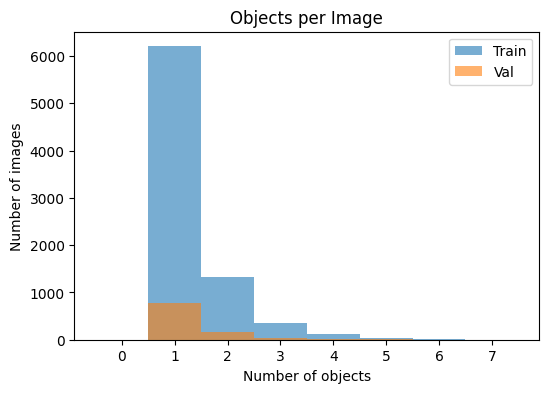

In [ ]:
# =========================
# (EDA-1) 객체 분포 & 이미지당 굴뚝 개수
# =========================
# 각 이미지에 굴뚝이 몇 개 있는지 확인하고, Train/Val 데이터셋을 비교합니다.

def objects_per_image(ann_dict):
    # ann_dict = {filename: [boxes...]} 형태
    # 파일마다 box 개수를 확인합니다.
    return [len(v) for v in ann_dict.values()]

train_objs_per_img = objects_per_image(train_ann)
val_objs_per_img   = objects_per_image(val_ann)

print("\n=== Objects per Image (summary) ===")
def describe_counts(name, counts):
    if len(counts)==0:
        print(f"{name}: no labels")
        return
    arr = np.array(counts)
    print(f"{name}: N={len(arr)} | mean={arr.mean():.3f} | median={np.median(arr):.3f} | min={arr.min()} | max={arr.max()}")

describe_counts("Train", train_objs_per_img)
describe_counts("Val",   val_objs_per_img)

# 히스토그램으로 시각화 (Train/Val 비교)
plt.figure(figsize=(6,4))
bins = np.arange(0, max(train_objs_per_img+val_objs_per_img+[1])+2) - 0.5
plt.hist(train_objs_per_img, bins=bins, alpha=0.6, label='Train')
plt.hist(val_objs_per_img,   bins=bins, alpha=0.6, label='Val')
plt.title("Objects per Image")
plt.xlabel("Number of objects")
plt.ylabel("Number of images")
plt.legend()
plt.show()

### 바운딩 박스 크기/비율/면적 분포


=== Box Width summary ===
Train: N=10619, mean=68.16, median=61.00, min=6.00, max=334.00
Val:   N=1322, mean=69.19, median=60.00, min=9.00, max=333.00

=== Box Height summary ===
Train: N=10619, mean=44.59, median=32.00, min=5.00, max=270.00
Val:   N=1322, mean=43.22, median=31.00, min=6.00, max=270.00

=== Aspect Ratio summary ===
Train: N=10619, mean=2.26, median=2.10, min=0.12, max=9.00
Val:   N=1322, mean=2.32, median=2.30, min=0.15, max=8.31

=== Box Area (pixels) summary ===
Train: N=10619, mean=3324.83, median=1952.00, min=135.00, max=51040.00
Val:   N=1322, mean=3278.79, median=1939.00, min=147.00, max=43230.00

=== Normalized Width summary ===
Train: N=10619, mean=0.13, median=0.12, min=0.01, max=0.65
Val:   N=1322, mean=0.14, median=0.12, min=0.02, max=0.65

=== Normalized Height summary ===
Train: N=10619, mean=0.09, median=0.06, min=0.01, max=0.53
Val:   N=1322, mean=0.08, median=0.06, min=0.01, max=0.53


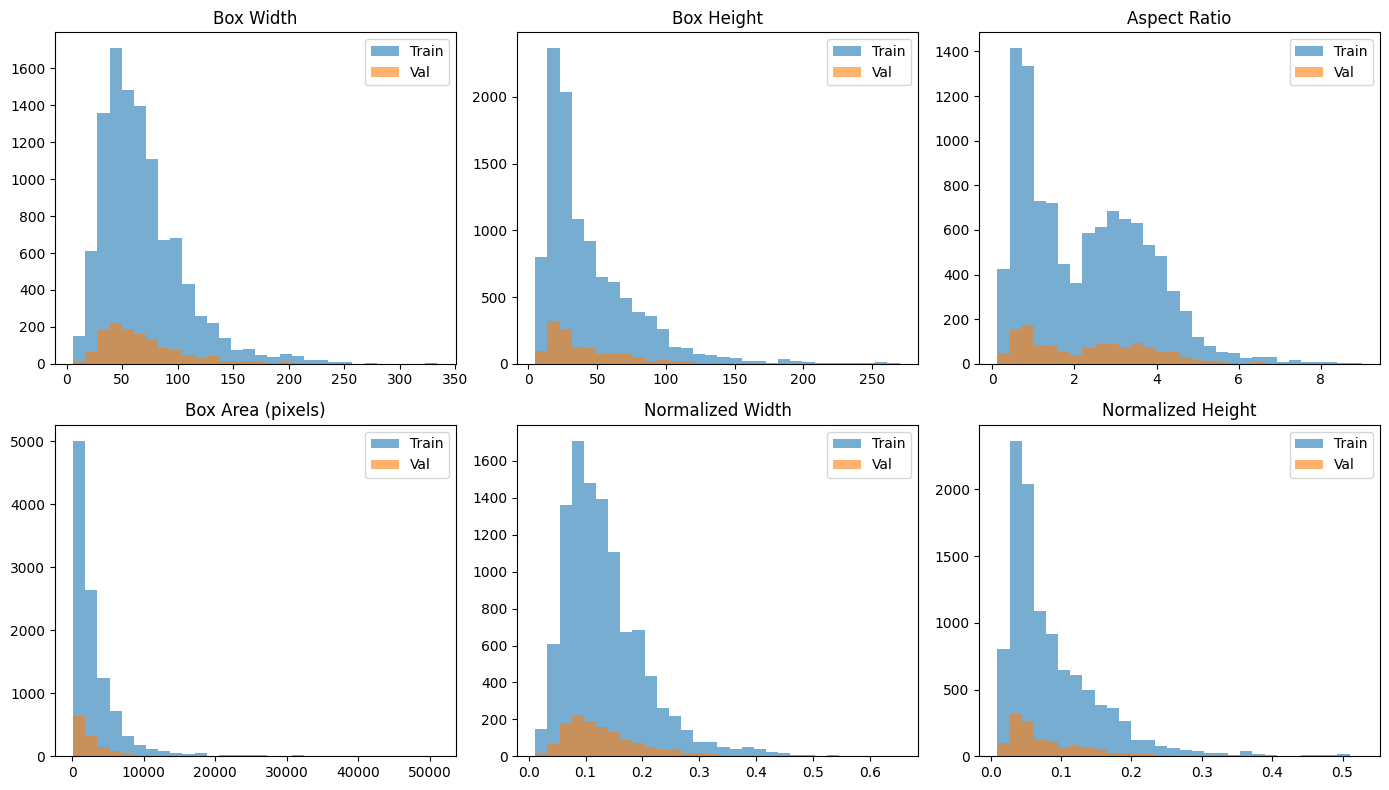

In [ ]:
# =========================
# (EDA-2) 바운딩박스 크기/비율/면적 분포
# =========================
# 바운딩 박스의 너비, 높이, 비율, 면적 분포를 Train/Val로 비교합니다.

def add_box_features(df):
    df = df.copy()
    df['area']   = df['w'] * df['h']                                 # 면적
    df['aspect'] = df['w'] / np.clip(df['h'], 1e-6, None)            # 가로/세로 비
    if IMG_SIZE is not None:
        H, W = IMG_SIZE
        df['area_norm'] = df['area'] / (W * H)                       # 정규화 면적
        df['w_norm']    = df['w'] / W
        df['h_norm']    = df['h'] / H
    return df

df_all_feat = add_box_features(df_all)

# 6가지 특성에 대해 Train/Val 히스토그램 출력 & 통계 요약
fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.ravel()

for i, (col, title) in enumerate([
    ('w',       'Box Width'),
    ('h',       'Box Height'),
    ('aspect',  'Aspect Ratio'),
    ('area',    'Box Area (pixels)'),
    ('w_norm',  'Normalized Width'),
    ('h_norm',  'Normalized Height'),
]):
    tr = df_all_feat[df_all_feat['split']=='train'][col].dropna().values
    va = df_all_feat[df_all_feat['split']=='val'][col].dropna().values

    # 숫자 요약
    print(f"\n=== {title} summary ===")
    if len(tr)>0:
        print(f"Train: N={len(tr)}, mean={np.mean(tr):.2f}, median={np.median(tr):.2f}, "
              f"min={np.min(tr):.2f}, max={np.max(tr):.2f}")
    else:
        print("Train: no data")
    if len(va)>0:
        print(f"Val:   N={len(va)}, mean={np.mean(va):.2f}, median={np.median(va):.2f}, "
              f"min={np.min(va):.2f}, max={np.max(va):.2f}")
    else:
        print("Val: no data")

    # 히스토그램
    if len(tr)==0 and len(va)==0:
        axes[i].text(0.5, 0.5, "No data", ha='center', va='center')
        continue
    data = np.concatenate([tr, va]) if (len(tr)>0 and len(va)>0) else (tr if len(tr)>0 else va)
    bins = np.histogram_bin_edges(data, bins=30)
    axes[i].hist(tr, bins=bins, alpha=0.6, label='Train')
    axes[i].hist(va, bins=bins, alpha=0.6, label='Val')
    axes[i].set_title(title)
    axes[i].legend()

plt.tight_layout()
plt.show()

### 위치 분포 Heatmap (Box Center Distribution)


=== Train Box Center Summary ===
Count: 10619
X mean=262.41, median=269.00, min=6.50, max=498.50
Y mean=259.79, median=251.50, min=5.00, max=506.50


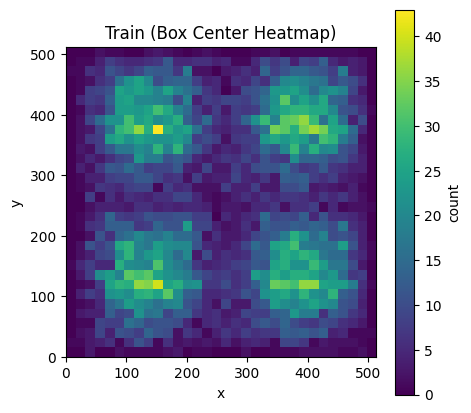


=== Val Box Center Summary ===
Count: 1322
X mean=258.69, median=250.75, min=6.50, max=506.00
Y mean=265.65, median=280.00, min=8.50, max=501.50


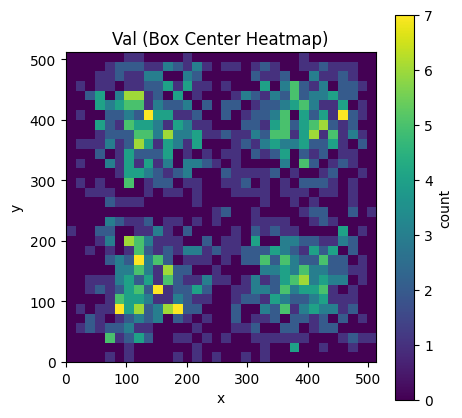

In [ ]:
# =========================
# (EDA-3) 위치 분포 Heatmap (Box Center Distribution)
# =========================
# 굴뚝 박스가 이미지 어디에 많이 위치하는지를 확인합니다.

def centers_heatmap(df, title, H=IMG_SIZE[0], W=IMG_SIZE[1], bins=32):
    if len(df)==0:
        print(f"[{title}] No data to show.")
        return

    cx = df['x'] + df['w']/2.0
    cy = df['y'] + df['h']/2.0
    cx = np.clip(cx, 0, W); cy = np.clip(cy, 0, H)

    # 숫자 요약
    print(f"\n=== {title} Box Center Summary ===")
    print(f"Count: {len(cx)}")
    print(f"X mean={np.mean(cx):.2f}, median={np.median(cx):.2f}, min={np.min(cx):.2f}, max={np.max(cx):.2f}")
    print(f"Y mean={np.mean(cy):.2f}, median={np.median(cy):.2f}, min={np.min(cy):.2f}, max={np.max(cy):.2f}")

    # 2D 히트맵
    heat, xedges, yedges = np.histogram2d(cx, cy, bins=[bins, bins], range=[[0,W],[0,H]])
    plt.figure(figsize=(5,5))
    plt.imshow(heat.T, origin='lower', extent=[0,W,0,H], aspect='equal')
    plt.colorbar(label='count')
    plt.title(title + " (Box Center Heatmap)")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

centers_heatmap(df_all_feat[df_all_feat['split']=='train'], "Train")
centers_heatmap(df_all_feat[df_all_feat['split']=='val'],   "Val")


### 샘플 시각화 (라벨 오버레이)


=== Sample Visualization: Train ===


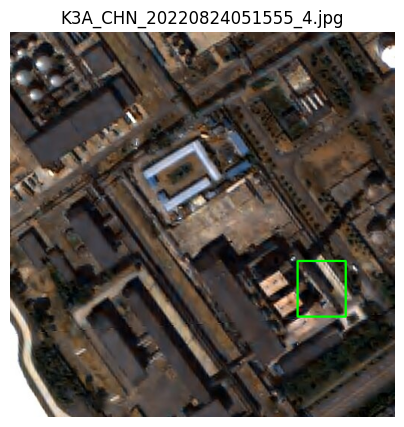

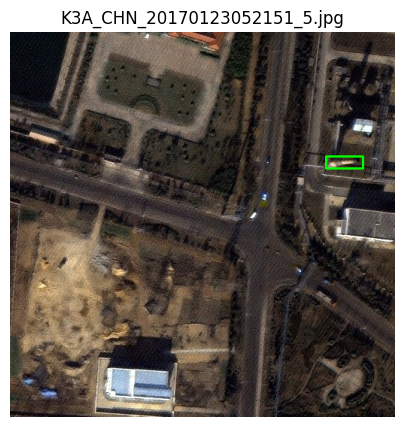

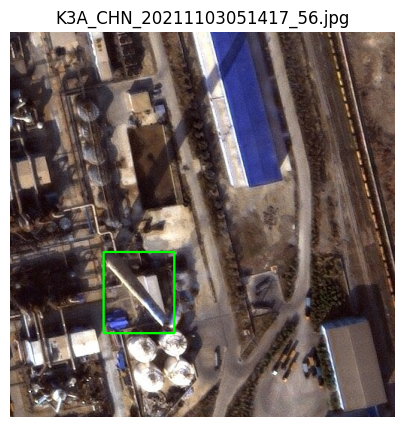

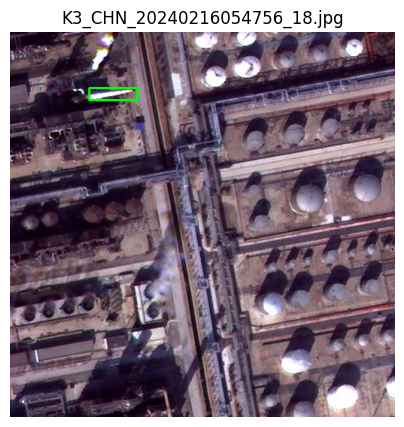

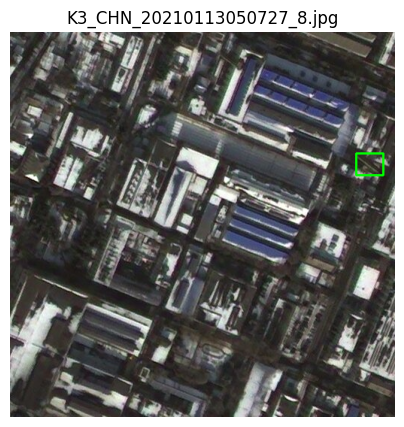

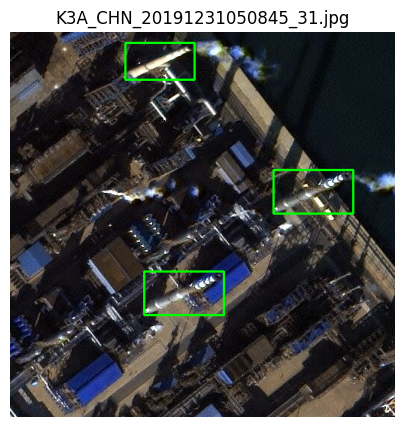


=== Sample Visualization: Val ===


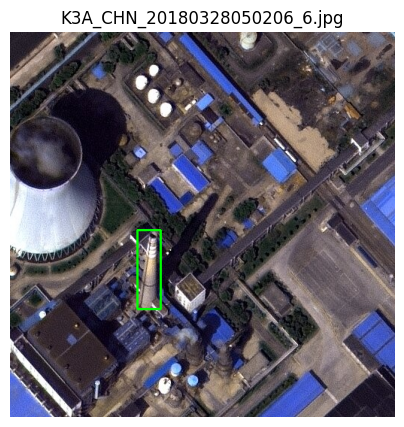

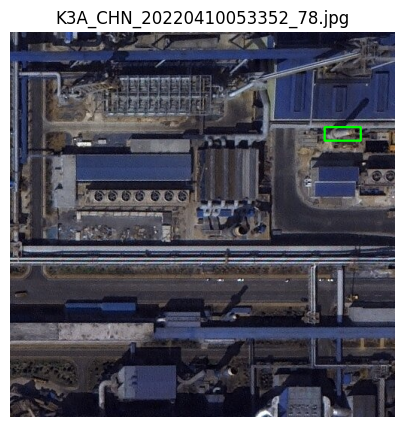

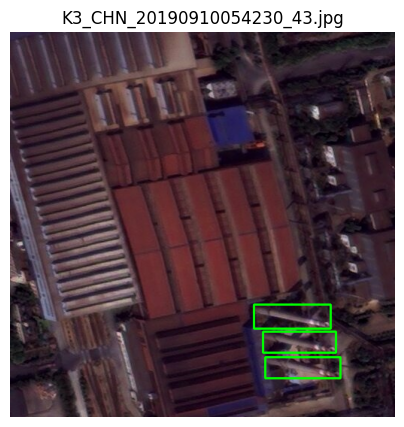

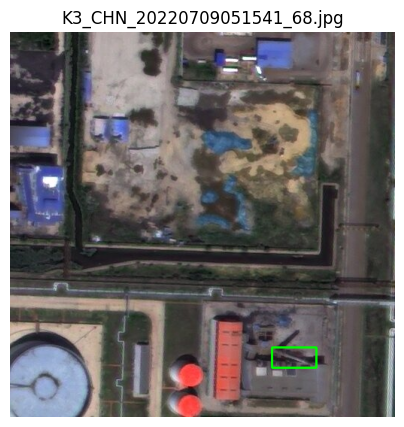

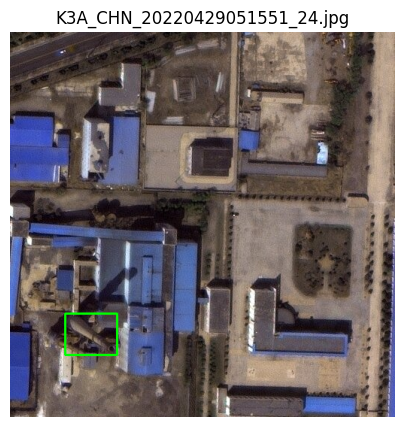

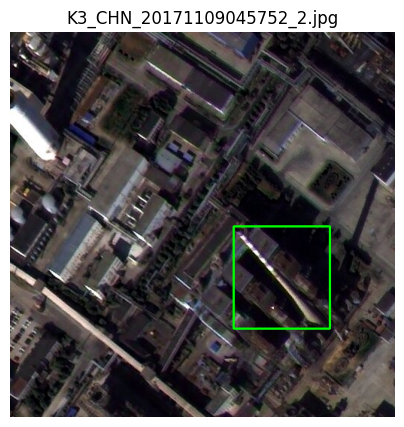

In [ ]:
# =========================
# (EDA-4) 샘플 시각화 (라벨 오버레이)
# =========================
def _get_box_xywh(b):
    # w/h 또는 width/height 어떤 키를 쓰든 안전하게 파싱합니다.
    x = float(b.get('x', 0))
    y = float(b.get('y', 0))
    w = float(b.get('w', b.get('width', 0)))
    h = float(b.get('h', b.get('height', 0)))
    return x, y, w, h

def draw_boxes(img, boxes, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    for b in boxes:
        x, y, w, h = _get_box_xywh(b)
        if w <= 0 or h <= 0:       # 잘못된 박스 방지
            continue
        x1 = int(np.clip(x,     0, W-1))
        y1 = int(np.clip(y,     0, H-1))
        x2 = int(np.clip(x+w,   0, W-1))
        y2 = int(np.clip(y+h,   0, H-1))
        if x2 <= x1 or y2 <= y1:
            continue
        cv2.rectangle(img, (x1,y1), (x2,y2), color, thickness)
    return img

def show_samples(img_dir, ann_dict, n=6):
    files = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1] in IMG_EXTS]
    random.shuffle(files)

    # stem 기준으로 라벨 조회(매칭률 ↑)
    ann_lookup = { _stem(k): v for k, v in ann_dict.items() }

    shown = 0
    for f in files:
        key = _stem(f)
        if key not in ann_lookup:
            continue
        img_path = os.path.join(img_dir, f)
        img = cv2.imread(img_path)
        if img is None:
            continue
        vis = draw_boxes(img.copy(), ann_lookup[key])
        vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(5,5))
        plt.title(f)
        plt.imshow(vis_rgb)
        plt.axis('off')
        plt.show()

        shown += 1
        if shown >= n:
            break

    if shown == 0:
        print("No samples to show. (Check filename matching between images and labels)")

print("\n=== Sample Visualization: Train ===")
show_samples(TRAIN_IMG_DIR, train_ann, n=6)

print("\n=== Sample Visualization: Val ===")
show_samples(VAL_IMG_DIR,   val_ann,   n=6)


### 데이터 품질 점검

In [ ]:
# =========================
# (EDA-5) 데이터 품질 점검
# =========================
def quality_checks(df, img_dir, ann_dict, img_size=IMG_SIZE):
    H, W = img_size
    issues = {}

    # a) 크기 이슈 (0 또는 음수) 정의
    size_bad = df[(df['w']<=0) | (df['h']<=0)]
    issues['size_bad'] = size_bad

    # b) 경계 밖(부분 또는 완전) 정의
    out_left  = df[df['x'] < 0]
    out_top   = df[df['y'] < 0]
    out_right = df[(df['x'] + df['w']) > W]
    out_bot   = df[(df['y'] + df['h']) > H]
    issues['out_of_bounds'] = pd.concat([out_left, out_top, out_right, out_bot]).drop_duplicates()

    # c) 라벨 누락(이미지는 있는데 라벨 없음)
    # stem으로 정확하게 비교합니다.
    img_files = { _stem(f) for f in os.listdir(img_dir) if os.path.splitext(f)[1] in IMG_EXTS }
    ann_files = { _stem(k) for k in ann_dict.keys() }
    no_label  = sorted(list(img_files - ann_files))
    issues['no_label'] = no_label

    # d) 중복 박스 확인
    dup = df.groupby(['filename','x','y','w','h']).size().reset_index(name='cnt')
    dup = dup[dup['cnt']>1]
    issues['duplicate_boxes'] = dup

    return issues

train_issues = quality_checks(df_train, TRAIN_IMG_DIR, train_ann, IMG_SIZE)
val_issues   = quality_checks(df_val,   VAL_IMG_DIR,   val_ann,   IMG_SIZE)

def report_issues(issues, split):
    print(f"\n=== 품질 점검 보고서: {split} ===")
    print(f"- 크기 0/음수 박스 개수: {len(issues['size_bad'])}")
    print(f"- 경계 벗어난 박스 개수(중복제거): {len(issues['out_of_bounds'])}")
    print(f"- 라벨 누락 이미지 수: {len(issues['no_label'])}")
    print(f"- 좌표 완전 중복 박스 그룹 수: {len(issues['duplicate_boxes'])}")

report_issues(train_issues, 'Train')
report_issues(val_issues,   'Val')


=== 품질 점검 보고서: Train ===
- 크기 0/음수 박스 개수: 0
- 경계 벗어난 박스 개수(중복제거): 2
- 라벨 누락 이미지 수: 0
- 좌표 완전 중복 박스 그룹 수: 0

=== 품질 점검 보고서: Val ===
- 크기 0/음수 박스 개수: 0
- 경계 벗어난 박스 개수(중복제거): 0
- 라벨 누락 이미지 수: 0
- 좌표 완전 중복 박스 그룹 수: 0


### Train vs Val 분포 비교

In [ ]:
# =========================
# (EDA-6) Train vs Val 분포 비교(요약 테이블)
# =========================
def summary_table(df):
    def s(x):
        if len(x)==0:
            return pd.Series({'count':0, 'mean':np.nan, 'median':np.nan, 'min':np.nan, 'max':np.nan})
        return pd.Series({
            'count':  len(x),
            'mean':   np.mean(x),
            'median': np.median(x),
            'min':    np.min(x),
            'max':    np.max(x),
        })
    feats = ['w','h','area','aspect','w_norm','h_norm','area_norm']
    out = []
    for split in ['train','val']:
        sub = df[df['split']==split]
        for f in feats:
            vals = sub[f].dropna().values
            out.append(pd.Series({'split':split, 'feature':f, **s(vals)}))
    return pd.DataFrame(out)

tbl = summary_table(df_all_feat)
try:
    display(tbl)
except:
    print(tbl)

split    feature    count         mean       median         min  \
0   train          w  10619.0    68.163481    61.000000    6.000000   
1   train          h  10619.0    44.587155    32.000000    5.000000   
2   train       area  10619.0  3324.828703  1952.000000  135.000000   
3   train     aspect  10619.0     2.257247     2.102564    0.125000   
4   train     w_norm  10619.0     0.133132     0.119141    0.011719   
5   train     h_norm  10619.0     0.087084     0.062500    0.009766   
6   train  area_norm  10619.0     0.012683     0.007446    0.000515   
7     val          w   1322.0    69.185325    60.000000    9.000000   
8     val          h   1322.0    43.220121    31.000000    6.000000   
9     val       area   1322.0  3278.789713  1939.000000  147.000000   
10    val     aspect   1322.0     2.319517     2.298148    0.148148   
11    val     w_norm   1322.0     0.135128     0.117188    0.017578   
12    val     h_norm   1322.0     0.084414     0.060547    0.011719   
13    val  area_norm   1322.0     0.012508     0.007397    0.000561   

             max  
0     334.000000  
1     270.000000  
2   51040.000000  
3       9.000000  
4       0.652344  
5       0.527344  
6       0.194702  
7     333.000000  
8     270.000000  
9   43230.000000  
10      8.307692  
11      0.650391  
12      0.527344  
13      0.164909

# 굴뚝 위치 탐지 (Object Detection)

 ■  Kompsat-3/3A 위성 이미지 (Training>TS_
 KS 폴더 내 데이터 8,052개로 학습,

Validation>VS_KS 폴더 내 데이터 1,006개
로 평가),

라벨링 데이터로 TL_KS_BBOX,
VL_KS_BBOX 을 사용

■  YOLOv8 등의 모델을 자유롭게 활용하여  
이미지 내 굴뚝 위치를 바운딩 박스 형태로
예측하시오.

 ■  mAP@IoU = 0.5 지표를 기반으로 평가함.
 “shape_attributes”:{“name”:”rect”,”x”:336,”y”:280,”width”:45,”height”:100}

### YOLO txt(정규화) 변환

In [ ]:
''' Module Import '''
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import os
from glob import glob
import glob

from google.colab import drive
drive.mount('/content/drive')

import json
import shutil
from tqdm import tqdm
import cv2
from pathlib import Path

# 경로 설정
base_path = '/content/drive/MyDrive/NIA/대기오염 배출원 공간 분포 데이터'

TRAIN_IMG_DIR = f"{base_path}/Training/01.원천데이터/TS_KS"
TRAIN_LBL_DIR = f"{base_path}/Training/02.라벨링데이터/TL_KS_BBOX"
VAL_IMG_DIR =   f"{base_path}/Validation/01.원천데이터/VS_KS"
VAL_LBL_DIR =   f"{base_path}/Validation/02.라벨링데이터/VL_KS_BBOX"

DEST_ROOT = '/content/smokestack_yolo_dataset' # 변환된 데이터 저장 경로


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 이미지 & JSON 파일 목록 매칭 (데이터 손실 방지)
def create_file_pairs(image_dir, label_dir):
    image_paths = []
    label_paths = []
    image_map = {Path(p).stem: p for p in glob.glob(os.path.join(image_dir, '*.*'))}

    for lbl_path in sorted(glob.glob(os.path.join(label_dir, '*.json'))):
        img_stem = Path(lbl_path).stem
        if img_stem in image_map:
            image_paths.append(image_map[img_stem])
            label_paths.append(lbl_path)
    return image_paths, label_paths

train_image_paths, train_label_paths = create_file_pairs(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
val_image_paths, val_label_paths = create_file_pairs(VAL_IMG_DIR, VAL_LBL_DIR)

print(f"매칭된 학습 데이터: {len(train_image_paths)}개 (원본: 8052)")
print(f"매칭된 검증 데이터: {len(val_image_paths)}개 (원본: 1006)")

매칭된 학습 데이터: 8052개 (원본: 8052)
매칭된 검증 데이터: 1006개 (원본: 1006)


In [ ]:
# YOLO 데이터셋 폴더 생성
if os.path.exists(DEST_ROOT): shutil.rmtree(DEST_ROOT)
print(f"\n--- YOLO 데이터셋 폴더를 '{DEST_ROOT}' 경로에 새로 생성합니다 ---")
os.makedirs(f'{DEST_ROOT}/images/train'); os.makedirs(f'{DEST_ROOT}/labels/train')
os.makedirs(f'{DEST_ROOT}/images/val'); os.makedirs(f'{DEST_ROOT}/labels/val')


--- YOLO 데이터셋 폴더를 '/content/smokestack_yolo_dataset' 경로에 새로 생성합니다 ---


In [ ]:
# 데이터 변환 함수
def convert_to_yolo_final(image_paths, label_paths, dest_img_dir, dest_lbl_dir):
    for img_path, lbl_path in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
        filename = os.path.basename(img_path)
        label_filename = os.path.splitext(filename)[0] + '.txt'

        image = cv2.imread(img_path)
        if image is None: continue
        img_height, img_width, _ = image.shape

        with open(lbl_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        yolo_labels = []
        json_content_key = list(data.keys())[0]
        annotations = data[json_content_key].get('regions', [])

        for ann in annotations:
            bbox = ann.get('shape_attributes')
            if not bbox or bbox.get('name') != 'rect': continue

            x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            norm_width = w / img_width
            norm_height = h / img_height
            yolo_labels.append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")

        # 이미지 파일은 항상 복사하며,
        # 라벨 내용은 yolo_labels 리스트에 따라 작성합니다.
        txt_path = os.path.join(dest_lbl_dir, label_filename)
        with open(txt_path, 'w') as f:
            f.write("\n".join(yolo_labels))

        shutil.copy(img_path, os.path.join(dest_img_dir, filename))

In [ ]:
convert_to_yolo_final(train_image_paths, train_label_paths,
                      f'{DEST_ROOT}/images/train', f'{DEST_ROOT}/labels/train')

print("\n--- 검증 데이터 변환 시작 ---")
convert_to_yolo_final(val_image_paths, val_label_paths,
                      f'{DEST_ROOT}/images/val', f'{DEST_ROOT}/labels/val')

print("\n\n 모든 데이터 변환 완료!")
print(f"생성된 학습 이미지: {len(os.listdir(f'{DEST_ROOT}/images/train'))}개")
print(f"생성된 학습 라벨: {len(os.listdir(f'{DEST_ROOT}/labels/train'))}개")
print(f"생성된 검증 이미지: {len(os.listdir(f'{DEST_ROOT}/images/val'))}개")
print(f"생성된 검증 라벨: {len(os.listdir(f'{DEST_ROOT}/labels/val'))}개")

100%|██████████| 8052/8052 [06:47<00:00, 19.75it/s]



--- 검증 데이터 변환 시작 ---


100%|██████████| 1006/1006 [16:19<00:00,  1.03it/s]



 모든 데이터 변환 완료!
생성된 학습 이미지: 8052개
생성된 학습 라벨: 8052개
생성된 검증 이미지: 1006개
생성된 검증 라벨: 1006개


# YOLOv8을 이용한 객체 탐지 (Object Detection)

**평가 데이터 사용 안내**

- Validation 데이터셋은 학습에 사용이 금지되어 있습니다.

- 다만, 평가 시 불필요한 데이터 누수 및 설정 차이를 최소화하기 위해
  
  inference 공통 설정값을 아래와 같이 지정합니다.


**Inference 설정 안내**

- confidence threshold: 0.25

- NMS IoU threshold: 0.50

- max detections: 100

In [ ]:
!pip install ultralytics -q

import os
from ultralytics import YOLO
import yaml

# YOLO 학습을 위한 YAML 설정 파일 생성
# ===================================================================
# 데이터 변환 코드에서 DEST_ROOT로 지정했던 경로를 그대로 사용합니다.
data_root_path = '/content/smokestack_yolo_dataset'
yaml_path = '/content/smokestack_dataset.yaml'

# YAML 파일에 들어갈 내용을 딕셔너리 형태로 정의합니다.
# 경로는 Colab의 로컬 경로를 가리킵니다.
data_yaml = {
    'train': os.path.join(data_root_path, 'images/train'),
    'val': os.path.join(data_root_path, 'images/val'),
    'nc': 1,  # number of classes: 클래스 개수 (굴뚝 1개)
    'names': ['chimney'] # 클래스 이름
}

# 딕셔너리를 YAML 파일로 저장합니다.
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f" YAML 파일이 성공적으로 생성되었습니다: {yaml_path}")
with open(yaml_path, 'r') as f:
    print("--- YAML 파일 내용 ---")
    print(f.read())


# ===================================================================
# YOLOv8 모델 학습
# ===================================================================
print("\n--- YOLOv8 모델 학습을 시작합니다 ---")

# 사전 훈련된 yolov8n 모델을 불러옵니다.
model = YOLO('yolov8n.pt')

# 모델을 훈련시킵니다.
# 미션에서 제시된 Inference 설정값은 val() 또는 predict() 단계에서 주로 사용되지만,
# patience, imgsz 등 주요 학습 파라미터는 여기서 설정합니다.
results = model.train(
    data=yaml_path,          # 방금 생성한 YAML 파일 경로
    epochs=50,               # 학습 횟수
    patience=10,             # early stopping rule
    imgsz=512,               # 입력 이미지 크기
    project='/content/drive/MyDrive/yolo_training_results', # 결과 저장 경로 (드라이브)
    name='mission1_run1',    # 실행 결과 저장 폴더
    exist_ok=True
)

print("\n\n 모델 학습이 완료되었습니다!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
 YAML 파일이 성공적으로 생성되었습니다: /content/smokestack_dataset.yaml
--- YAML 파일 내용 ---
names:
- chimney
nc: 1
train: /content/smokestack_yolo_dataset/images/train
val: /content/smokestack_yolo_dataset/images/val


--- YOLOv8 모델 학습을 시작합니다 ---
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/smokestack_data

--- '/content/drive/MyDrive/yolo_training_results/mission1_run1' 폴더에서 결과 이미지를 불러옵니다 ---

[ 혼동 행렬 (Confusion Matrix) ]


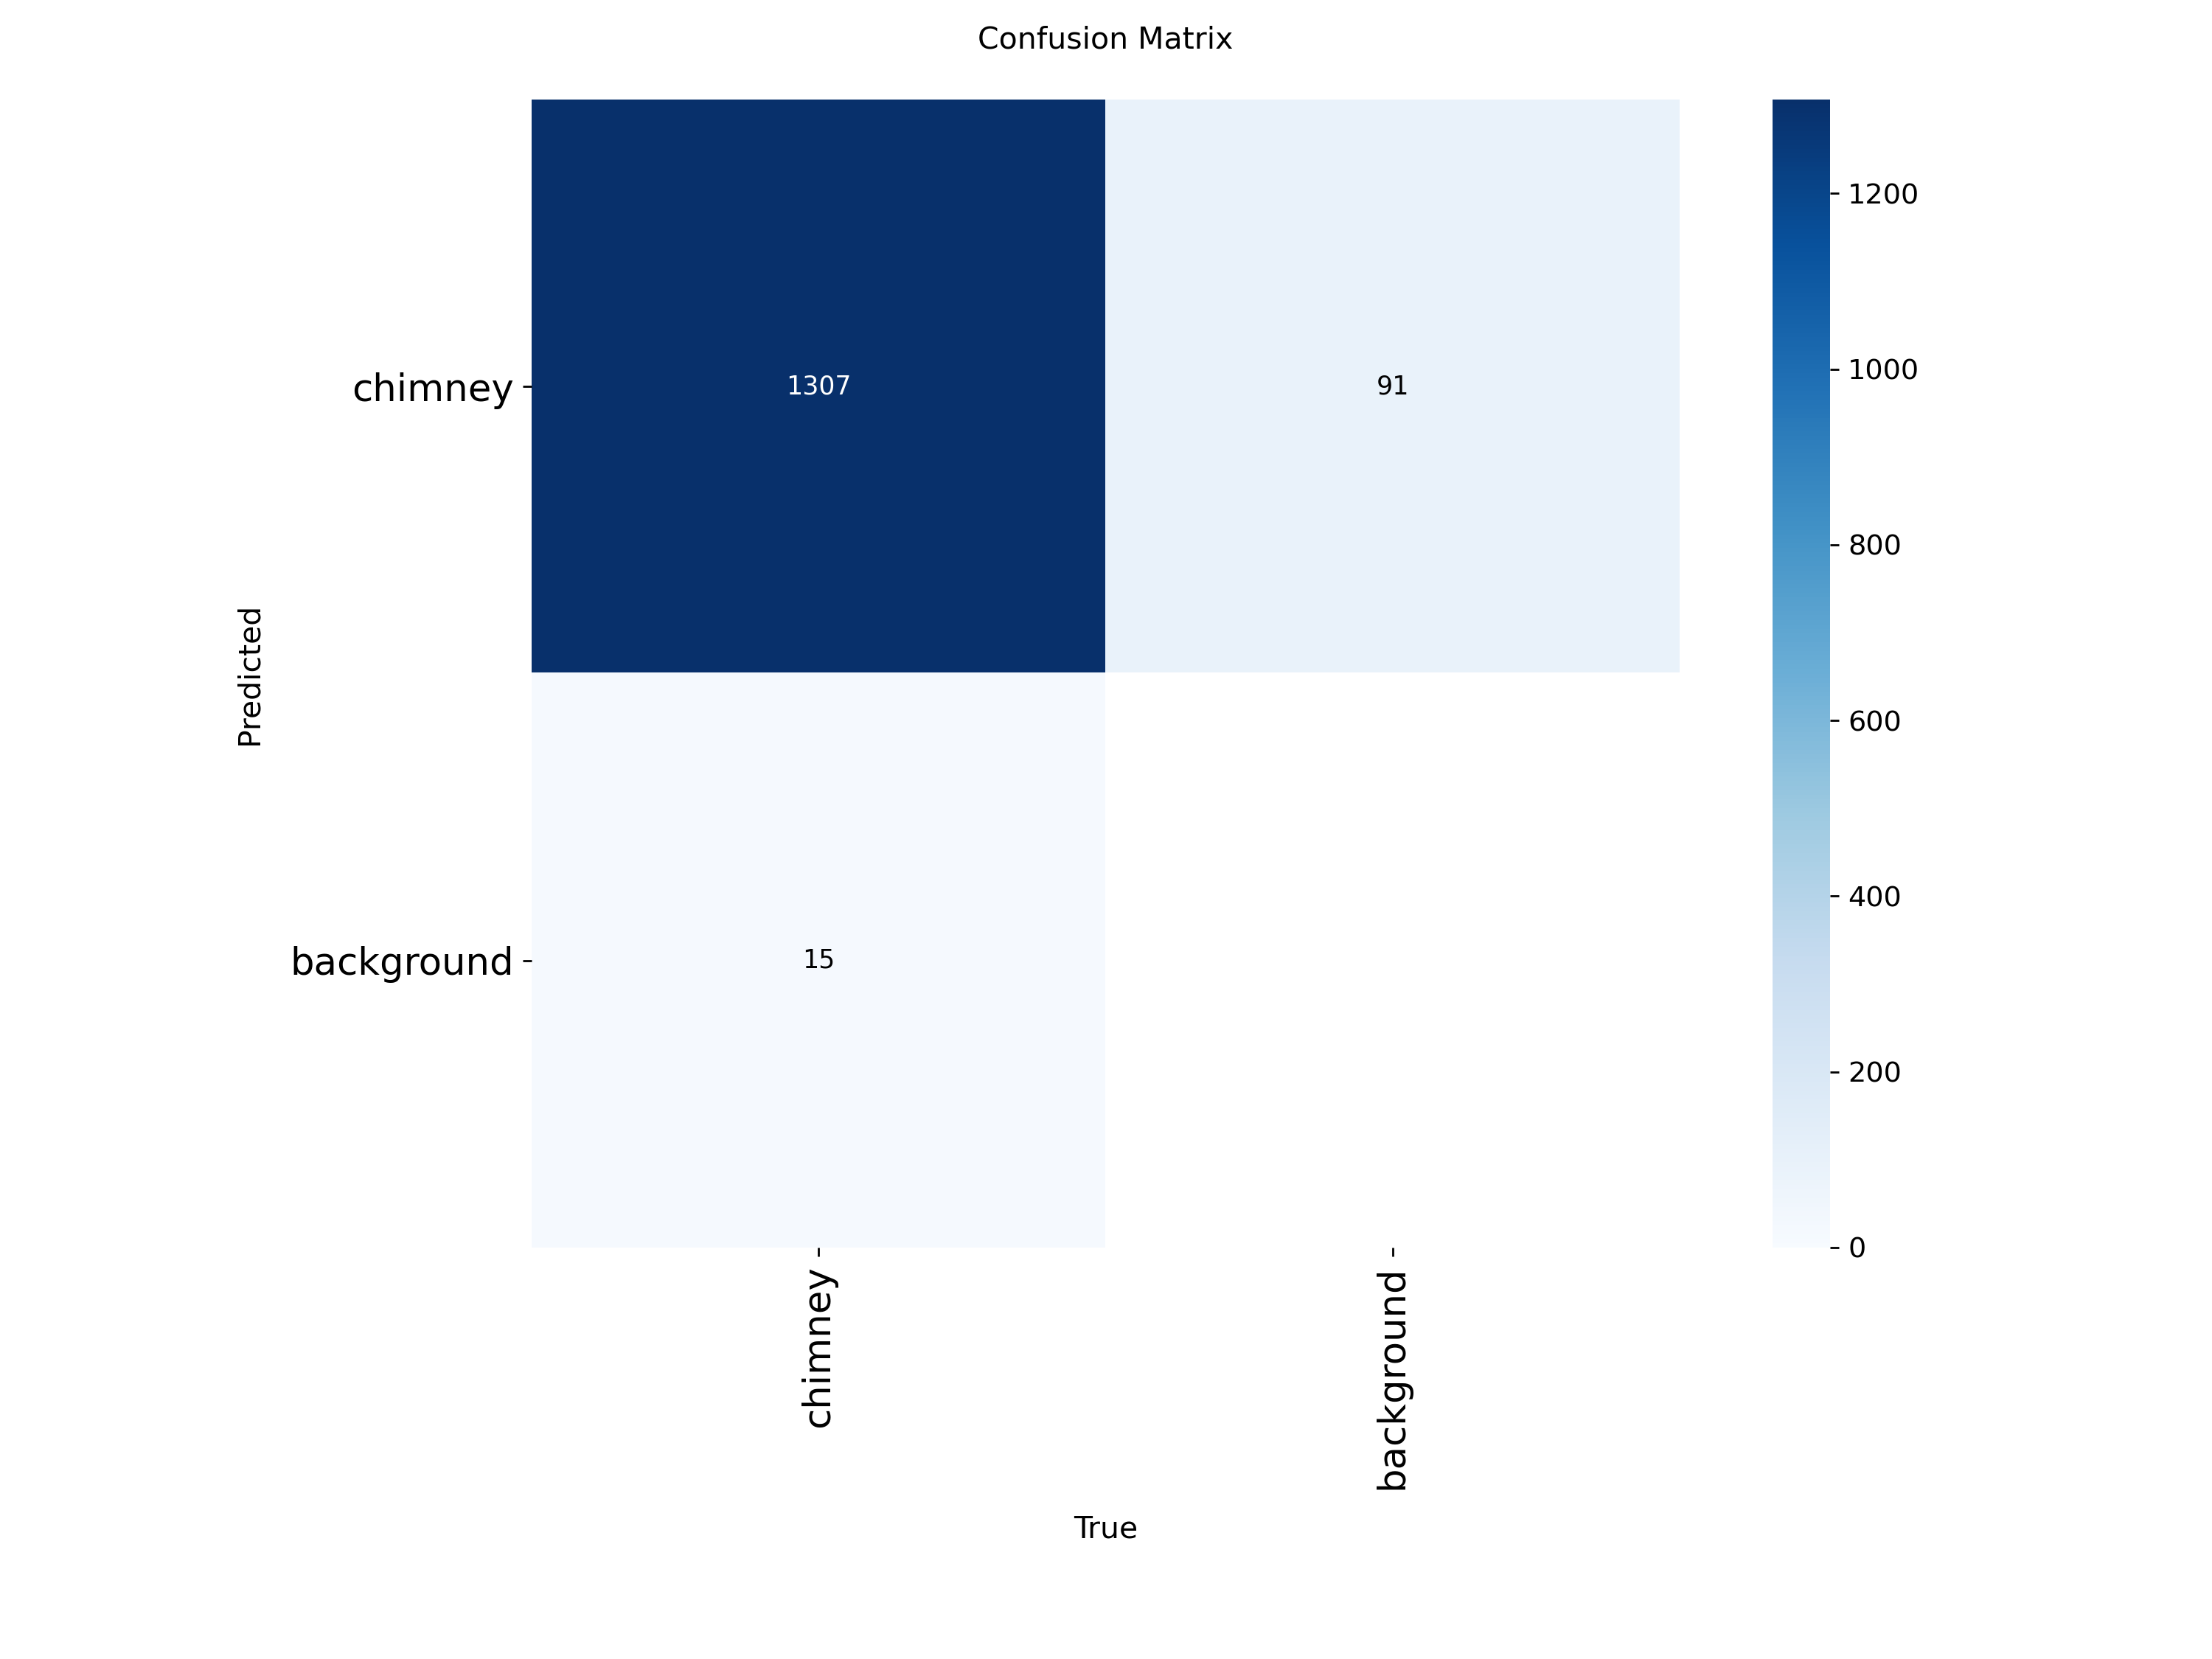


[ 학습 결과 그래프 ]


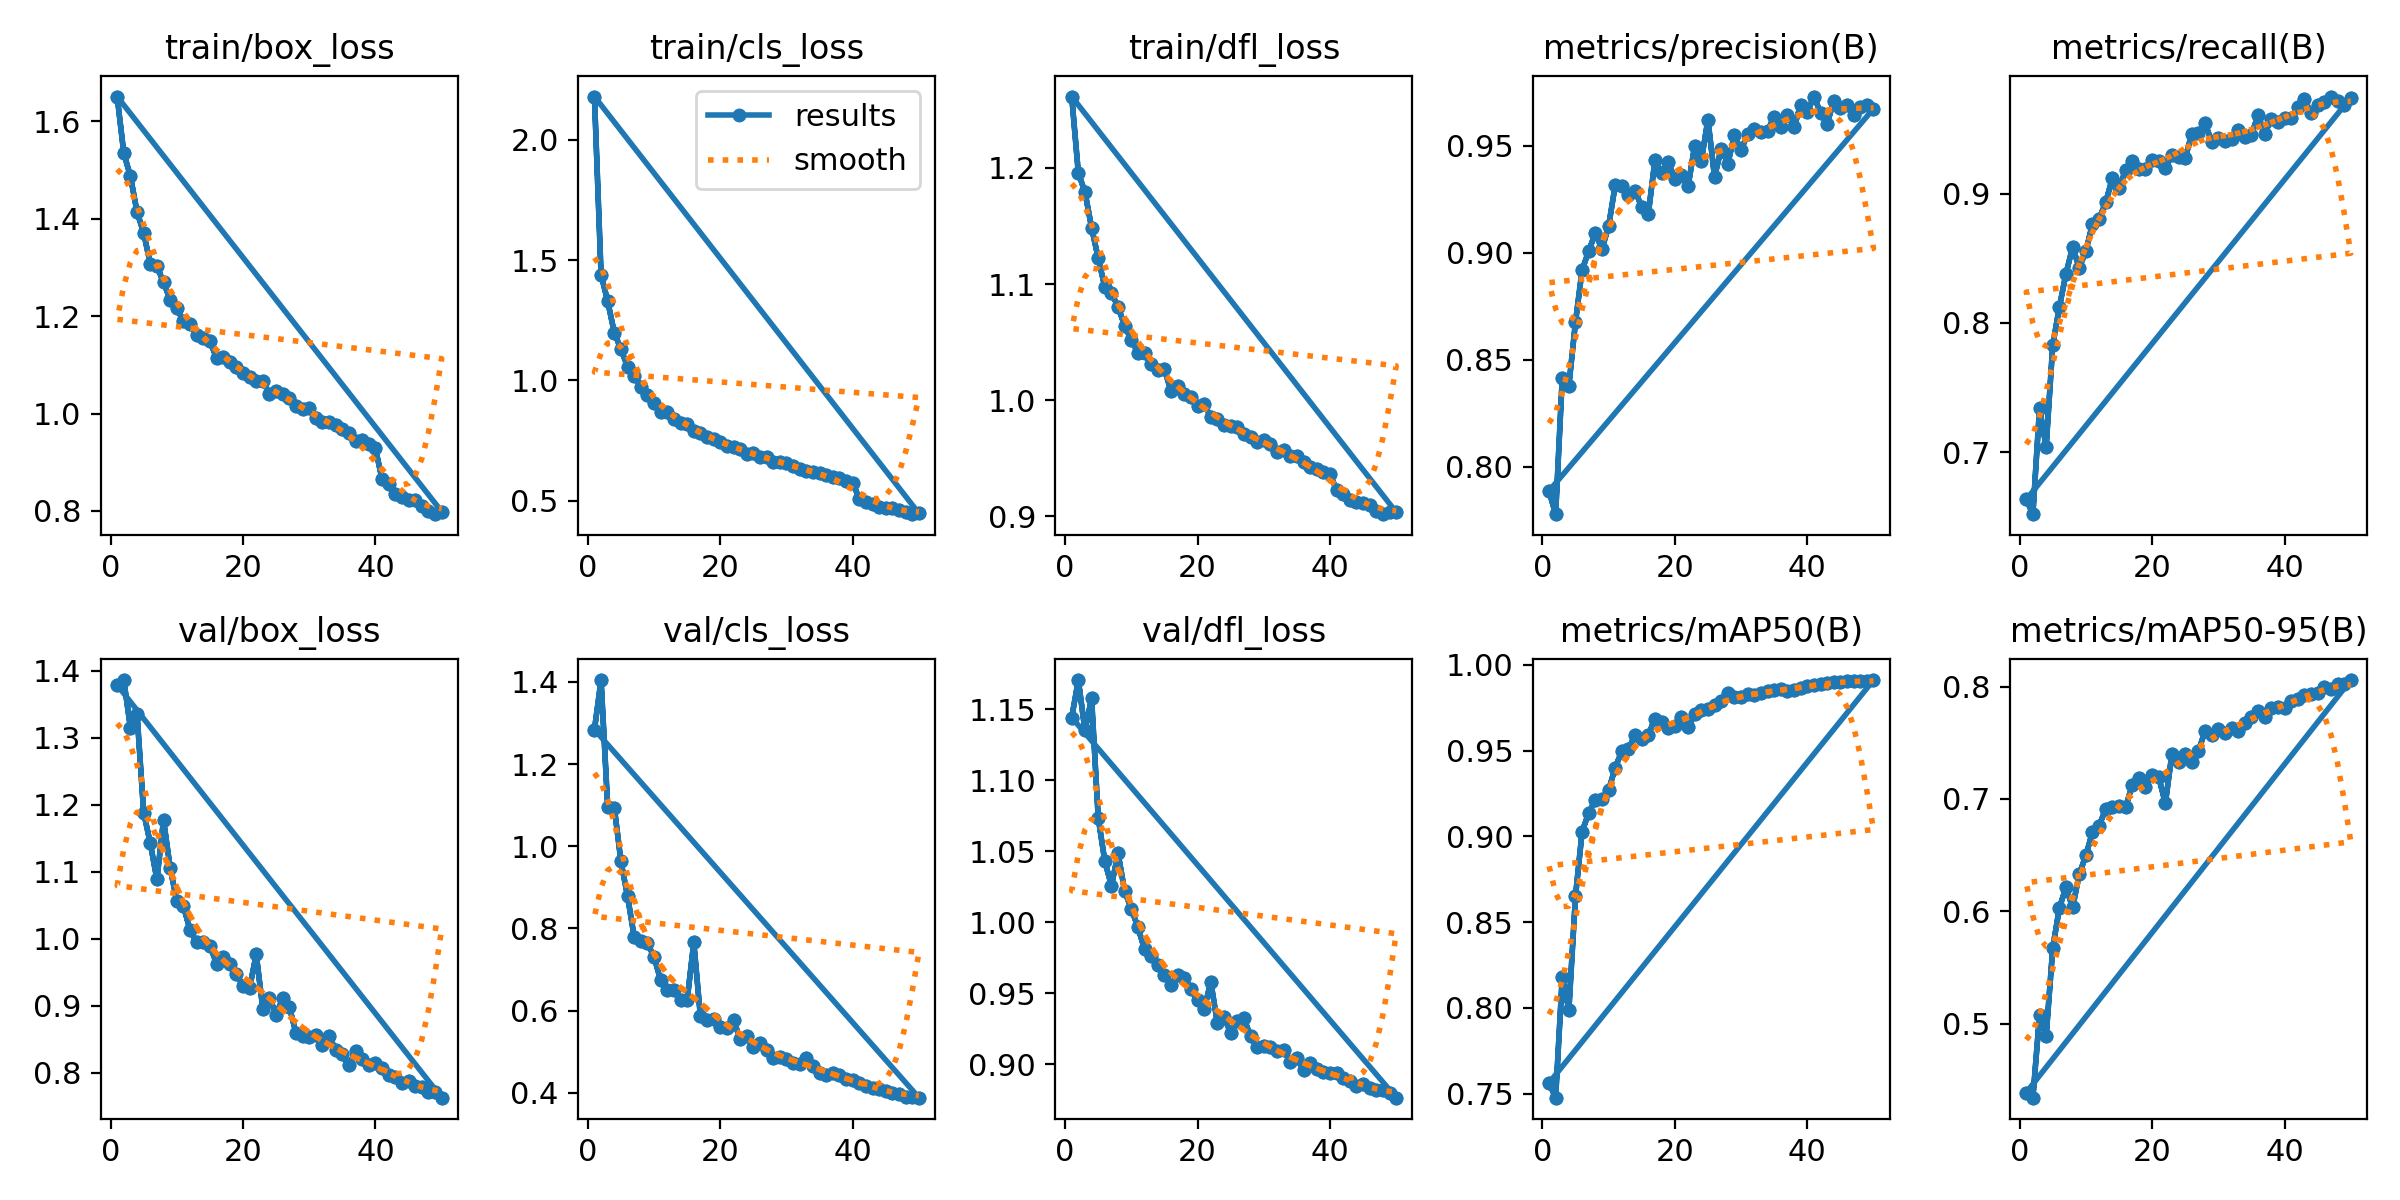


[ 검증 데이터 샘플 (Ground Truth) ]


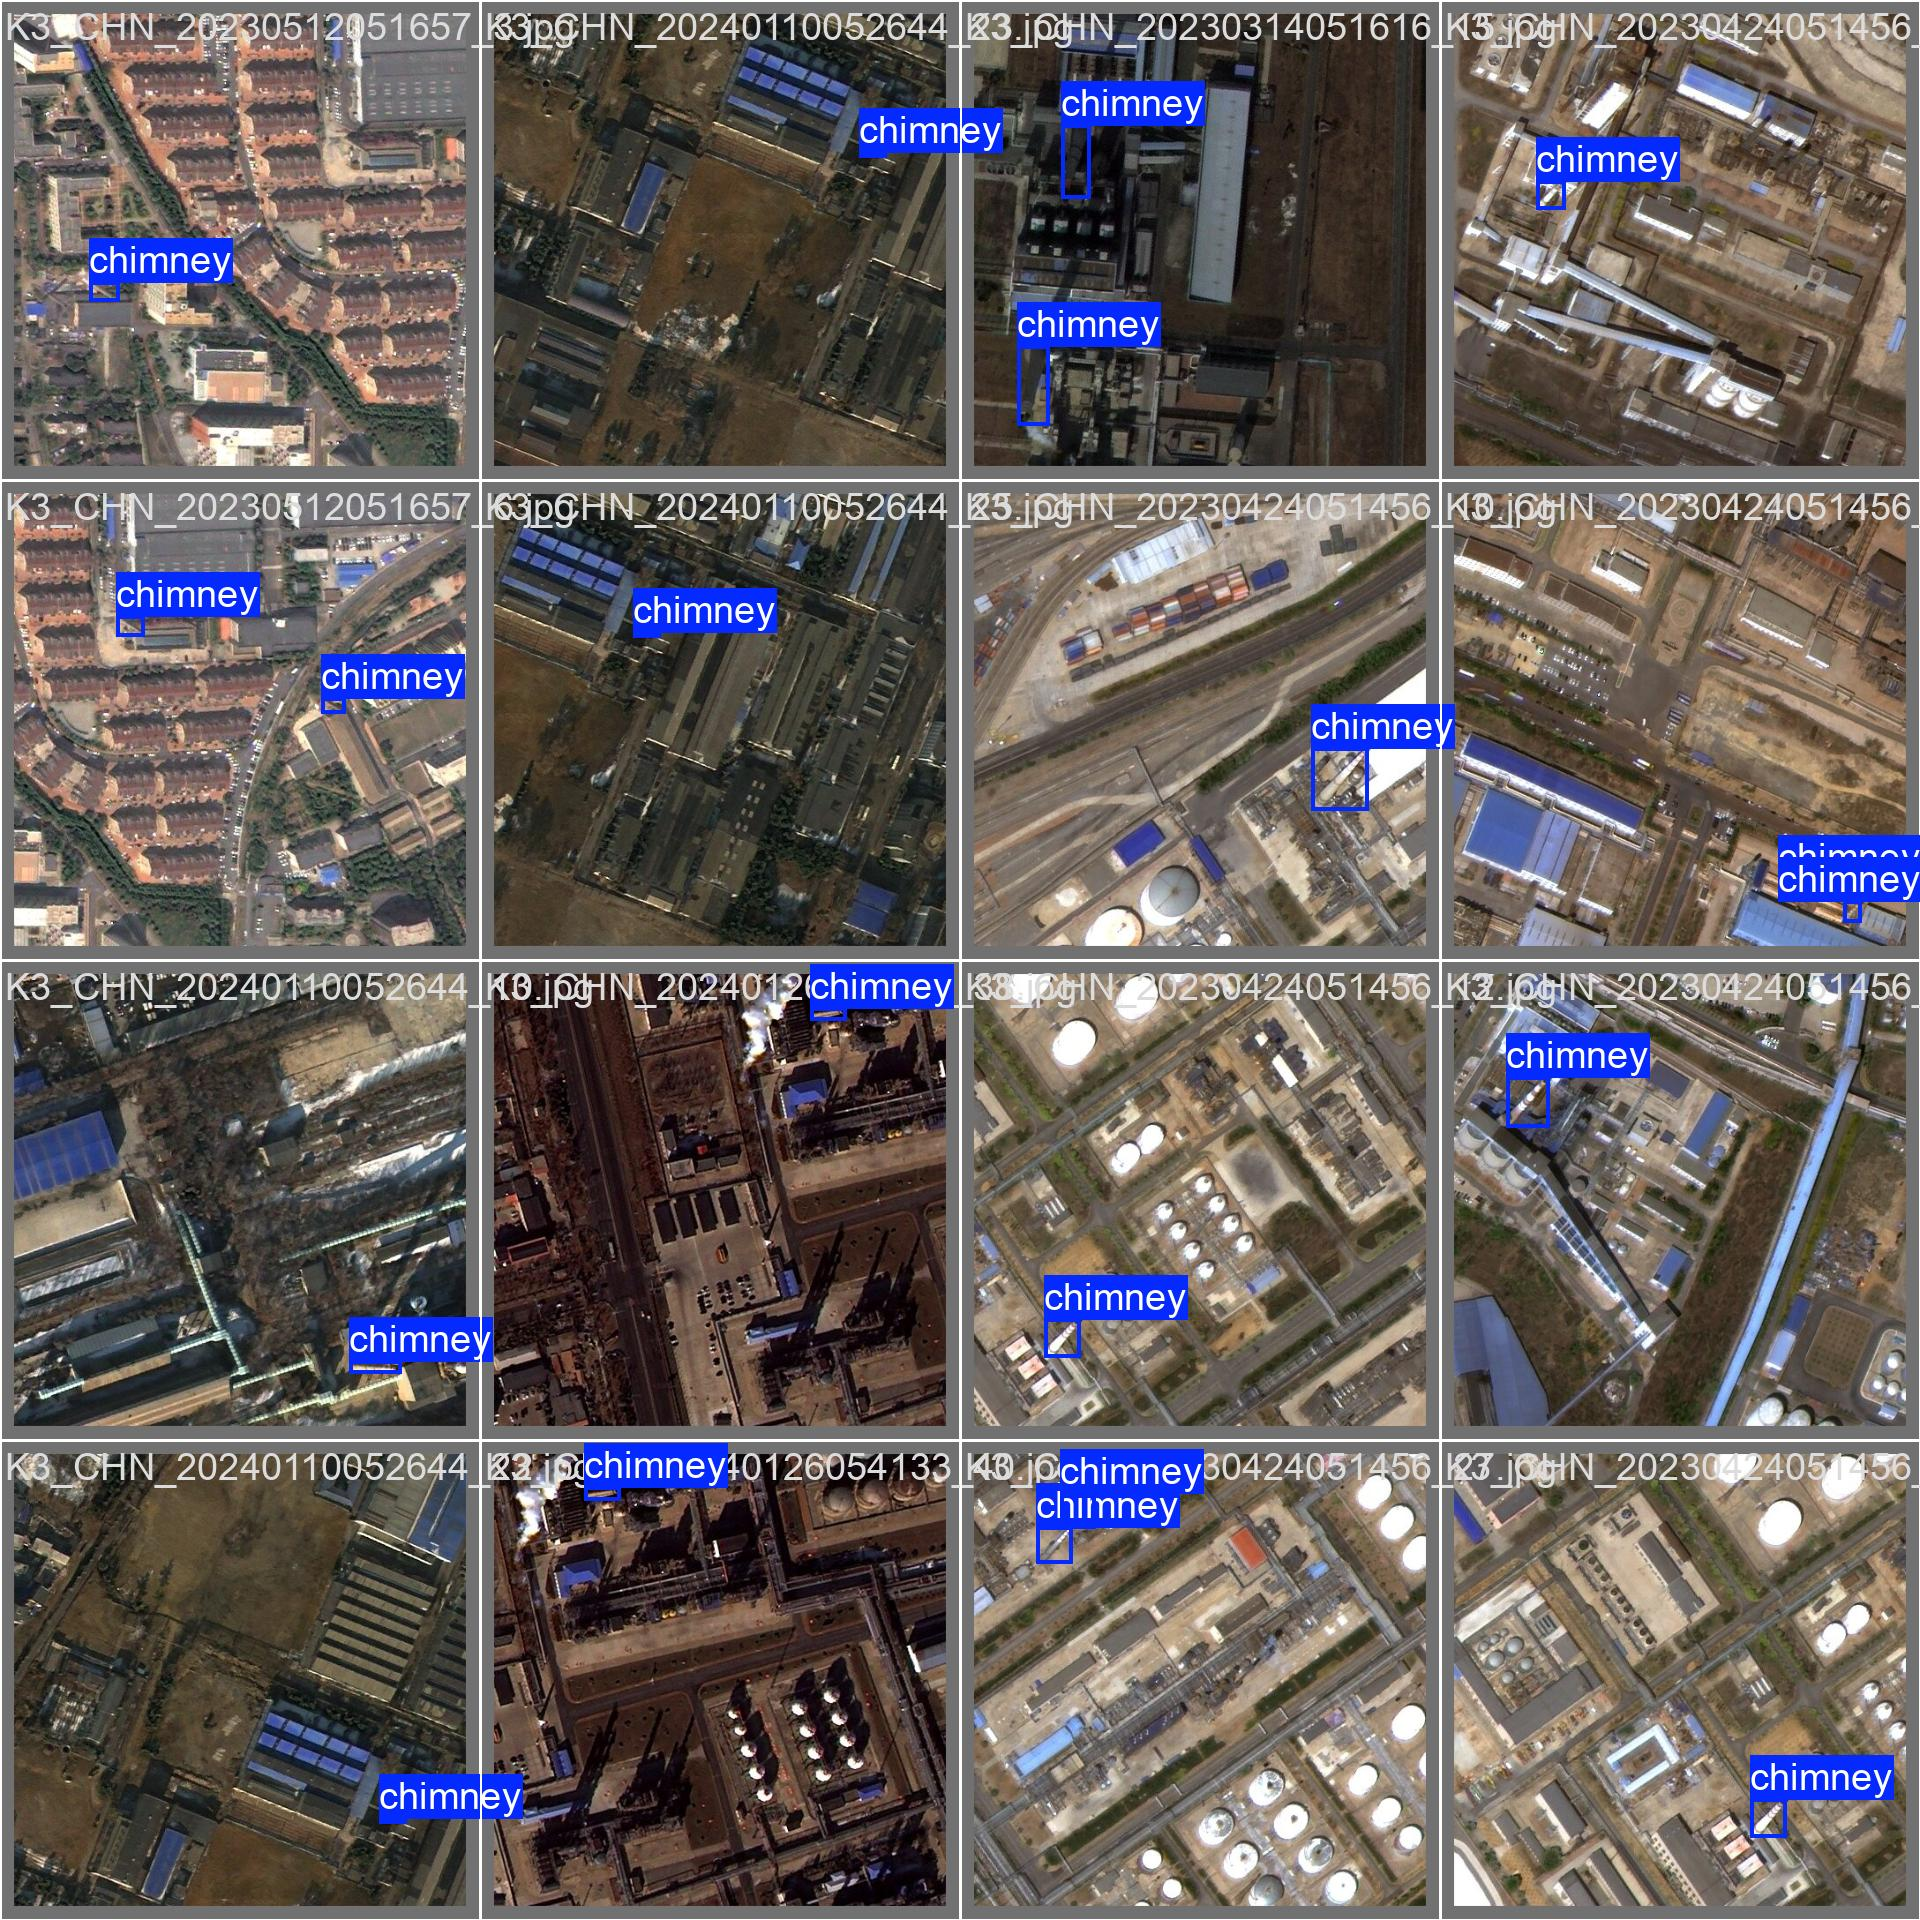


[ 검증 데이터 샘플 (Prediction) ]


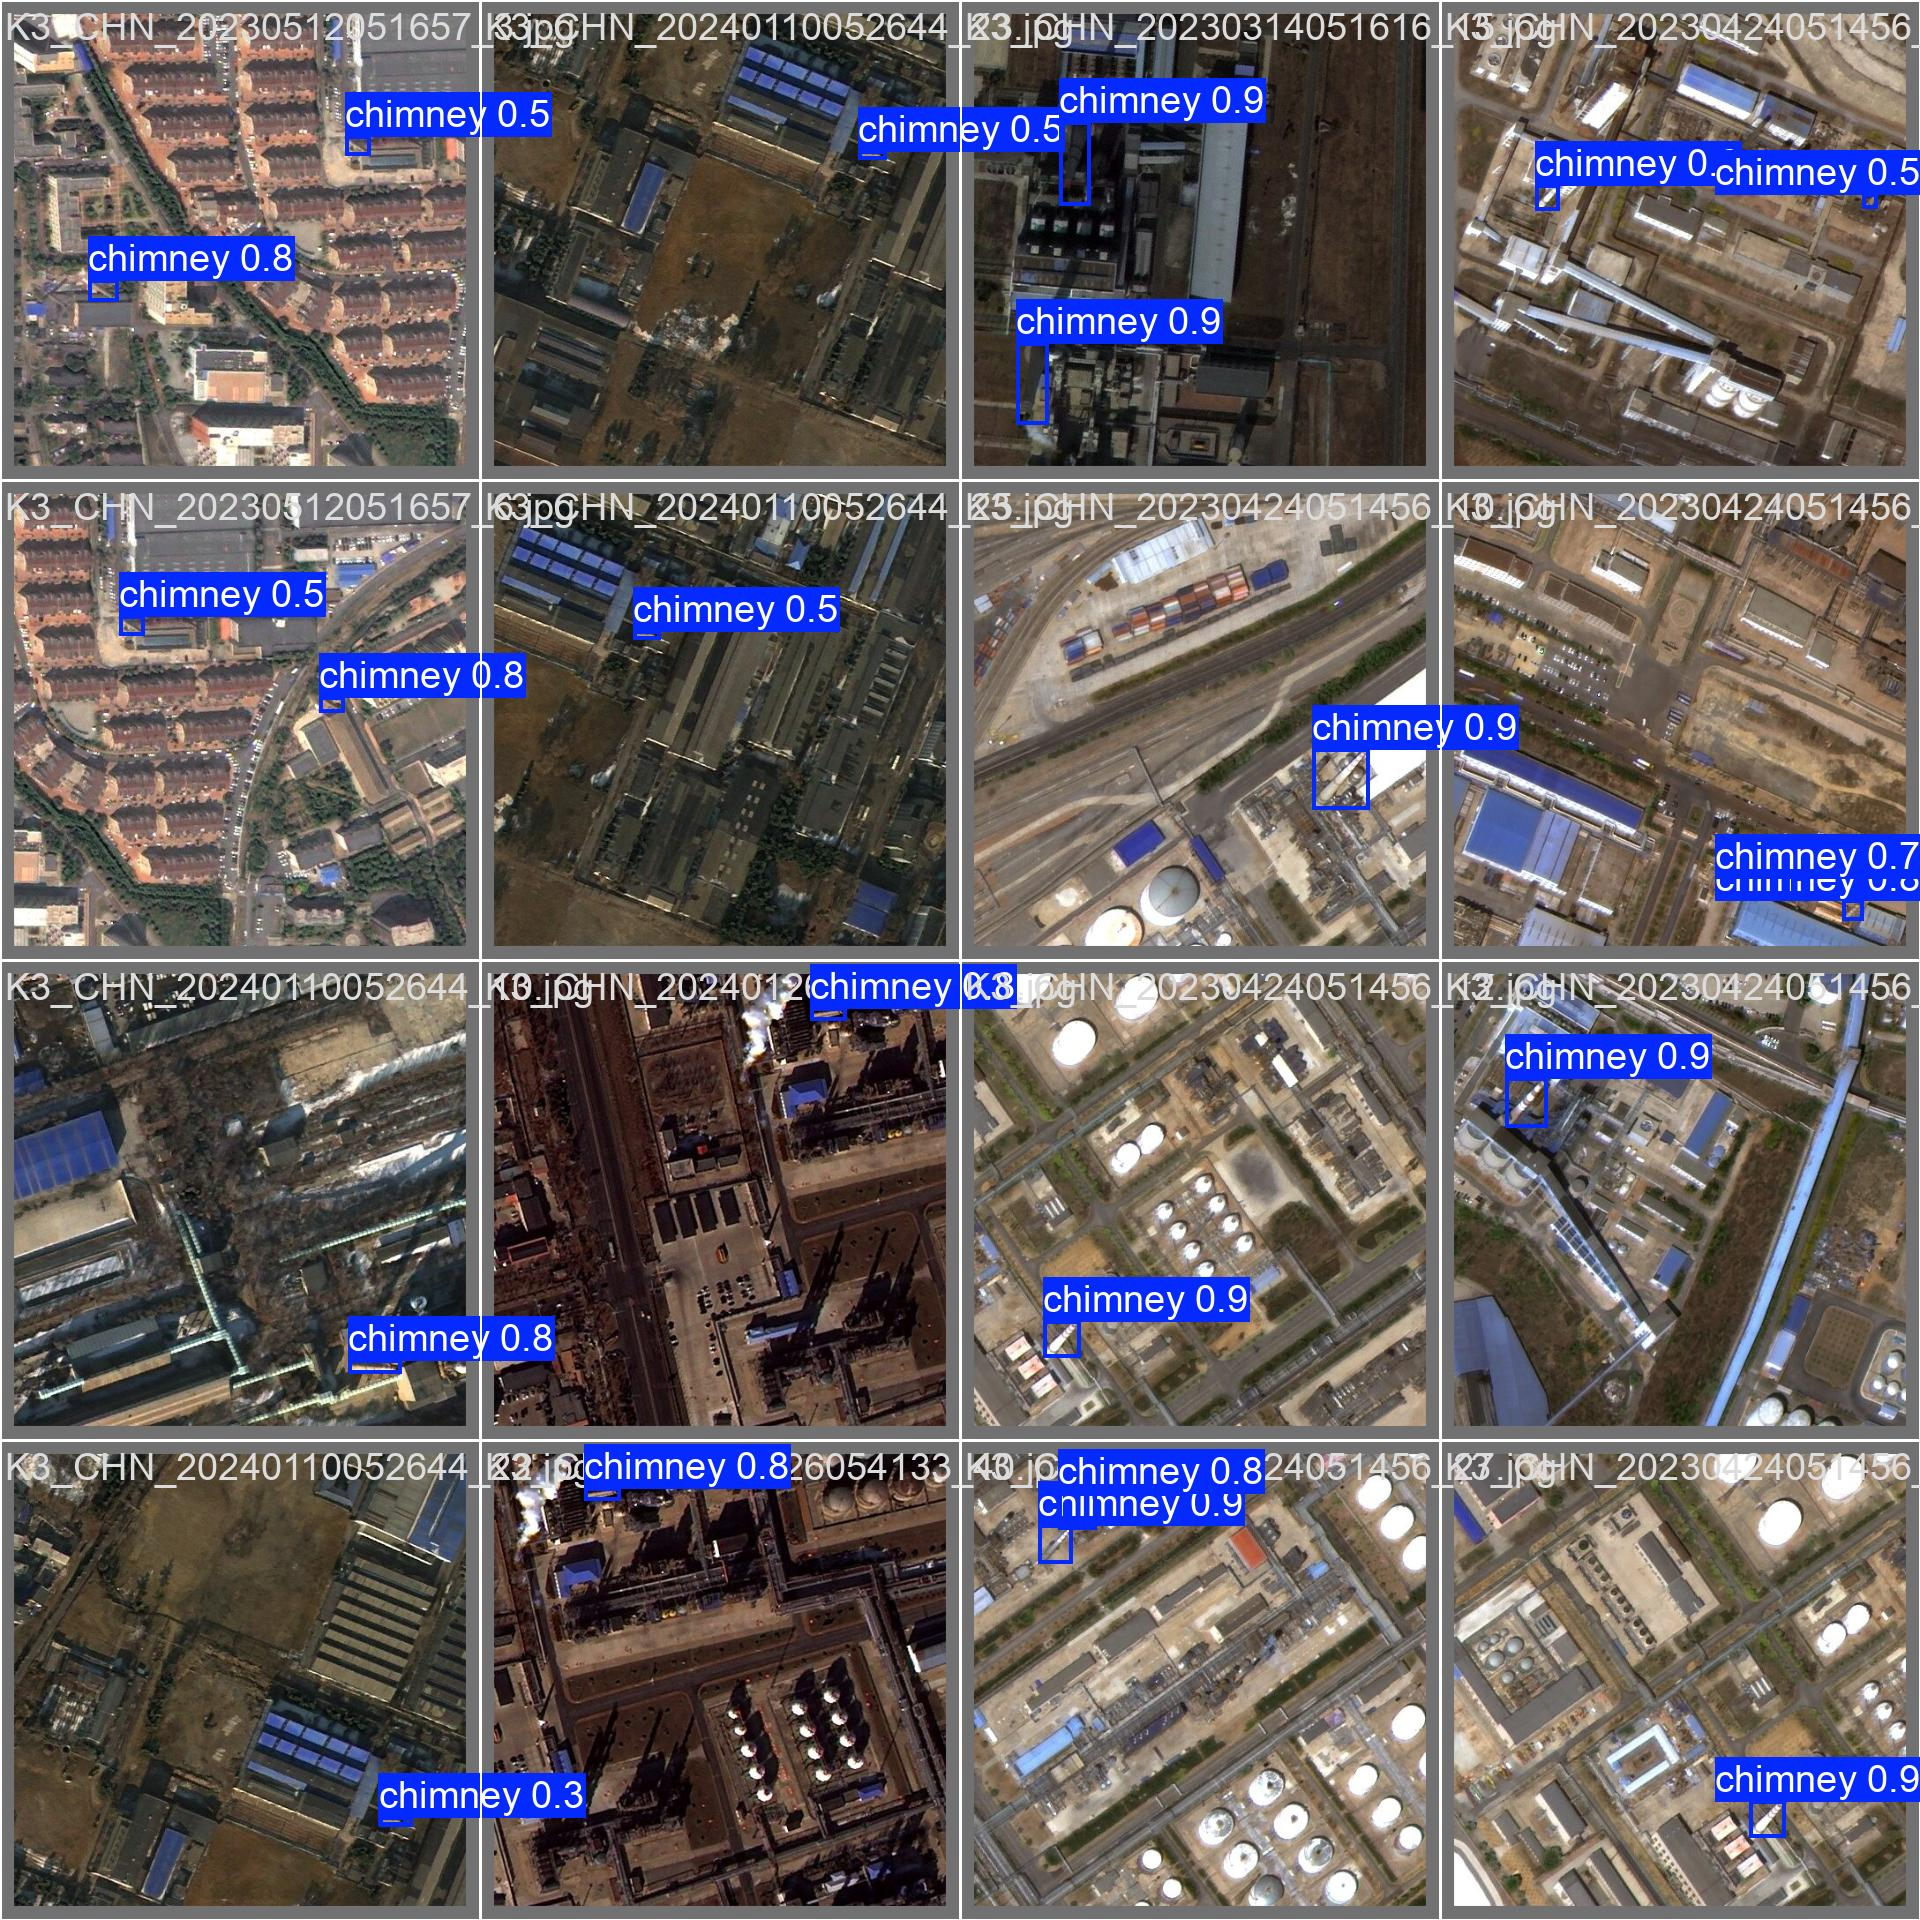

In [ ]:
from IPython.display import display, Image
import os

# ===================================================================
# 학습 결과 시각화
# ===================================================================

# 학습 결과가 저장된 폴더 경로를 지정합니다.
results_path = '/content/drive/MyDrive/yolo_training_results/mission1_run1'

print(f"--- '{results_path}' 폴더에서 결과 이미지를 불러옵니다 ---")

# 주요 결과 이미지 파일 경로
confusion_matrix_path = os.path.join(results_path, 'confusion_matrix.png')
results_graph_path = os.path.join(results_path, 'results.png')
val_batch0_labels_path = os.path.join(results_path, 'val_batch0_labels.jpg')
val_batch0_pred_path = os.path.join(results_path, 'val_batch0_pred.jpg')

# 혼동 행렬(Confusion Matrix) 시각화
if os.path.exists(confusion_matrix_path):
    print("\n[ 혼동 행렬 (Confusion Matrix) ]")
    display(Image(filename=confusion_matrix_path, width=600))
else:
    print("\n- 혼동 행렬 이미지를 찾을 수 없습니다.")

# 성능 그래프(Loss, mAP 등) 시각화
if os.path.exists(results_graph_path):
    print("\n[ 학습 결과 그래프 ]")
    display(Image(filename=results_graph_path, width=800))
else:
    print("\n- 학습 결과 그래프를 찾을 수 없습니다.")

# 검증 데이터 예측 결과 샘플 시각화
if os.path.exists(val_batch0_labels_path):
    print("\n[ 검증 데이터 샘플 (Ground Truth) ]")
    display(Image(filename=val_batch0_labels_path, width=600))
else:
    print("\n- 검증 데이터 샘플 이미지를 찾을 수 없습니다.")

if os.path.exists(val_batch0_pred_path):
    print("\n[ 검증 데이터 샘플 (Prediction) ]")
    display(Image(filename=val_batch0_pred_path, width=600))
else:
    print("\n- 검증 데이터 예측 이미지를 찾을 수 없습니다.")


**Inference 설정값(확인용)**

- confidence threshold: 0.25

- NMS IoU threshold: 0.50

- max detections: 100

--- 최종 예측(Inference)을 시작합니다 ---
적용된 모델: /content/drive/MyDrive/yolo_training_results/mission1_run1/weights/best.pt

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1006 /content/smokestack_yolo_dataset/images/val/K3A_CHN_20161112052404_15.jpg: 512x512 2 chimneys, 6.7ms
image 2/1006 /content/smokestack_yolo_dataset/images/val/K3A_CHN_20170115051130_1.jpg: 512x512 1 chimney, 6.3ms
image 3/1006 /content/smokestack_yolo_dataset/images/val/K3A_CHN_20170123052151_1.jpg: 512x512 1 chimney, 6.0ms
ima

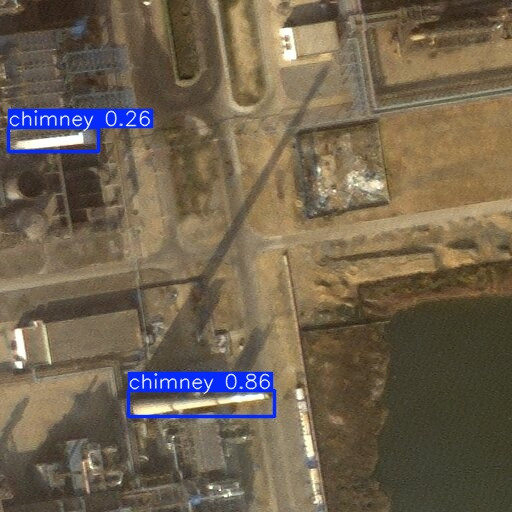

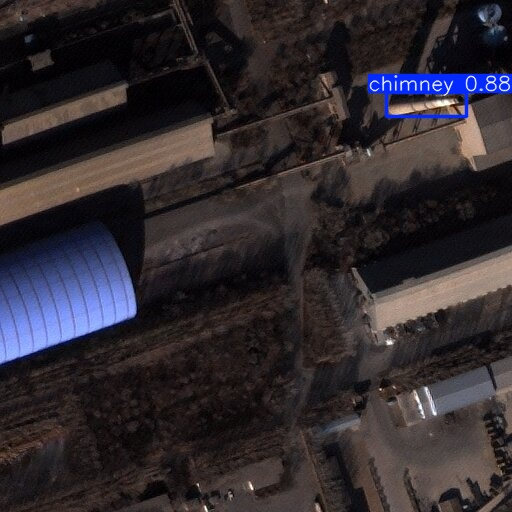

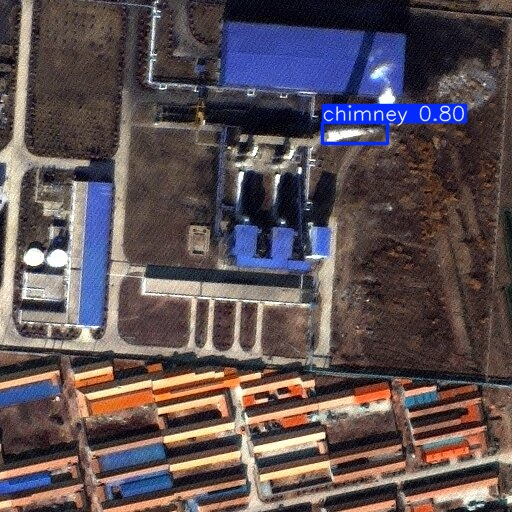

In [ ]:
# Inference 설정값 적용
from ultralytics import YOLO

# 가장 성능이 우수한 모델('best.pt')
best_model_path = '/content/drive/MyDrive/yolo_training_results/mission1_run1/weights/best.pt'
model = YOLO(best_model_path)

# 평가(Validation) 데이터셋 경로를 지정합니다.
#    이전에 생성했던 YOLO 데이터셋의 val 이미지 폴더입니다.
validation_image_dir = '/content/smokestack_yolo_dataset/images/val'


print(f"--- 최종 예측(Inference)을 시작합니다 ---")
print(f"적용된 모델: {best_model_path}")

# model.predict() 함수에 대회 공지 설정값을 인자로 넣어 실행합니다.
results = model.predict(
    source=validation_image_dir,
    imgsz=512,
    conf=0.25,                 # Confidence Threshold: 0.25
    iou=0.50,                  # NMS IoU Threshold: 0.50
    max_det=100,               # Max Detections: 100
    save=True,                 # 예측 결과(이미지 & 박스) 저장
    project='/content/drive/MyDrive/yolo_training_results', # 프로젝트 폴더(결과 저장)
    name='mission1_predictions' # 하위 폴더 이름
)

print(f"\n\n 예측이 완료되었습니다")
print(f"결과는 '/content/drive/MyDrive/yolo_training_results/mission1_predictions' 폴더에 저장되었습니다.")

# 예측 결과 중 일부를 화면에 바로 표시해서 확인합니다.
import glob
from IPython.display import Image, display

# 예측 결과 이미지 중 처음 3개를 확인합니다.
prediction_images = sorted(glob.glob('/content/drive/MyDrive/yolo_training_results/mission1_predictions/*.jpg'))[:3]

for img_path in prediction_images:
    display(Image(filename=img_path, width=600))